In [44]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score

In [45]:
dataset_dir = "/kaggle/input/jellyfish-types/Train_Test_Valid"

batch_size = 16
image_size = (224, 224)
epochs = 20

In [46]:
def plot_images(dataset_type, axes):
    class_directories = os.listdir(os.path.join(dataset_dir, dataset_type))
    
    for i, class_dir in enumerate(class_directories):
        
        image_files = os.listdir(os.path.join(dataset_dir, dataset_type, class_dir))
        
        random_image = random.choice(image_files)
        
        img = mpimg.imread(os.path.join(dataset_dir, dataset_type, class_dir, random_image))
        axes[i // 3, i % 3].imshow(img)
        axes[i // 3, i % 3].set_title(class_dir)
        axes[i // 3, i % 3].axis('off')

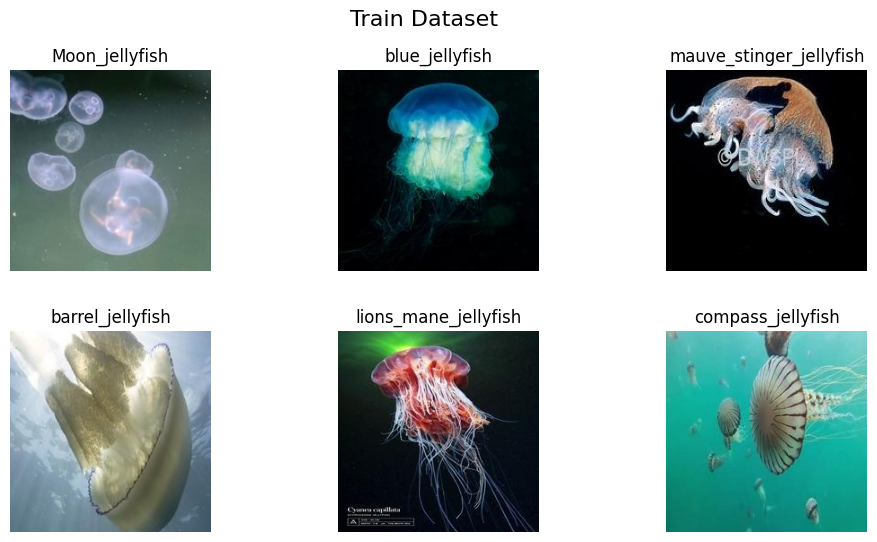

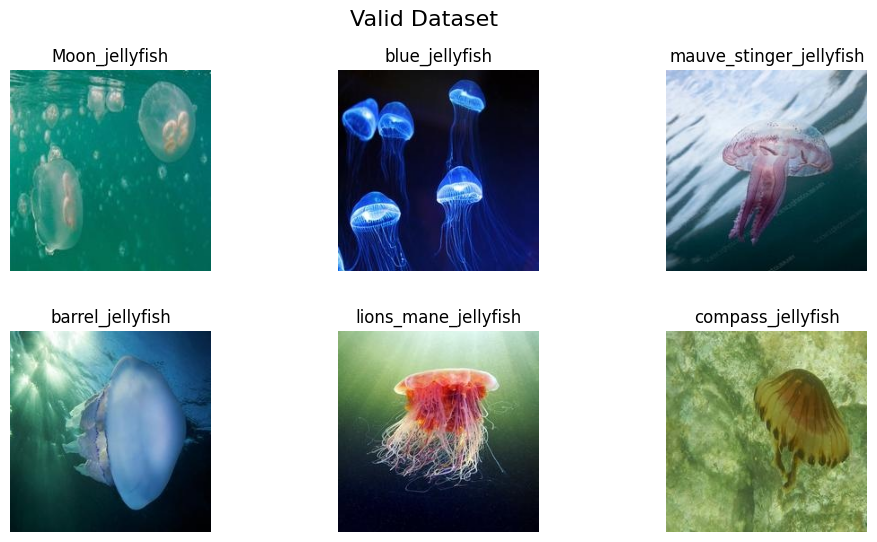

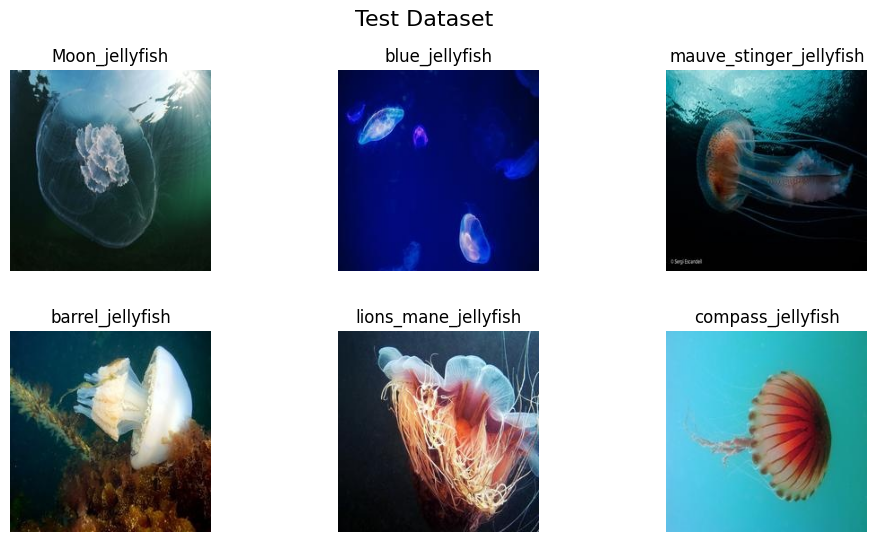

In [47]:
dataset_types = ['Train', 'valid', 'test']

for dataset_type in dataset_types:
    fig, axes = plt.subplots(2, 3, figsize=(12, 6))
    fig.suptitle(f"{dataset_type.capitalize()} Dataset", fontsize=16)
    fig.subplots_adjust(hspace=0.3)
    plot_images(dataset_type, axes)
    plt.show()

In [48]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'Train'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'valid'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

Found 900 images belonging to 6 classes.
Found 39 images belonging to 6 classes.


In [49]:
# model = keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),

#     tf.keras.layers.Flatten(),
#     # tf.keras.layers.Dropout(0.2),

#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(6, activation='softmax')
# ])
mmodel = tf.keras.applications.MobileNetV3Large(input_shape=(224,224,3),include_top=False,weights='imagenet')
mmodel.trainable = False
model=keras.models.Sequential()
model.add(mmodel)
model.add(keras.layers.Flatten()) 
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(6,activation=tf.nn.softmax))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 47040)             0         
                                                                 
 dropout_1 (Dropout)         (None, 47040)             0         
                                                                 
 dense_3 (Dense)             (None, 6)                 282246    
                                                                 
Total params: 3,278,598
Trainable params: 282,246
Non-trainable params: 2,996,352
_________________________________________________________________


In [50]:
early_stopping =EarlyStopping(patience=10, restore_best_weights=True)

In [51]:
model.compile(optimizer ='Adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/20
57/57 [==============================] - 8s 71ms/step - loss: 2.4542 - accuracy: 0.1900 - val_loss: 2.1876 - val_accuracy: 0.2051
Epoch 2/20
57/57 [==============================] - 3s 48ms/step - loss: 2.1489 - accuracy: 0.2389 - val_loss: 1.9392 - val_accuracy: 0.2051
Epoch 3/20
57/57 [==============================] - 3s 46ms/step - loss: 2.0772 - accuracy: 0.2778 - val_loss: 1.7683 - val_accuracy: 0.3077
Epoch 4/20
57/57 [==============================] - 3s 46ms/step - loss: 1.8952 - accuracy: 0.3111 - val_loss: 1.9723 - val_accuracy: 0.2308
Epoch 5/20
57/57 [==============================] - 3s 47ms/step - loss: 1.8187 - accuracy: 0.3567 - val_loss: 1.7991 - val_accuracy: 0.3590
Epoch 6/20
57/57 [==============================] - 3s 48ms/step - loss: 1.7714 - accuracy: 0.3644 - val_loss: 1.7751 - val_accuracy: 0.3077
Epoch 7/20
57/57 [==============================] - 3s 47ms/step - loss: 1.8084 - accuracy: 0.3856 - val_loss: 1.9181 - val_accuracy: 0.3846
Epoch 8/20
57

In [53]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=image_size,  
    batch_size=batch_size,
    class_mode="categorical",
)

Found 40 images belonging to 6 classes.


In [54]:
predictions = model.predict(test_generator)

predicted_labels = predictions.argmax(axis=1)

true_labels = test_generator.classes


class_names = list(test_generator.class_indices.keys())

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Set Accuracy: {accuracy:.2%}")

3/3 [==============================] - 1s 32ms/step
Test Set Accuracy: 25.00%


In [55]:
def plot_predictions(true_labels, predicted_labels, class_names, dataset_dir):
    num_images = len(true_labels)
    num_rows = 10
    num_cols = num_images // num_rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 18))
    fig.suptitle("Test Set Predictions", fontsize=16)
    fig.subplots_adjust(hspace=0.5)

    # Load and plot each image with true and predicted labels
    for i in range(num_images):
        img_path = os.path.join(os.path.join(dataset_dir, 'test'), test_generator.filenames[i])
        img = image.load_img(img_path, target_size=(400, 400))  # Adjust target_size as needed
        img_array = image.img_to_array(img) / 255.0
        true_label = class_names[true_labels[i]]
        predicted_label = class_names[predicted_labels[i]]

        row = i // num_cols
        col = i % num_cols

        axes[row, col].imshow(img_array)
        axes[row, col].set_title(f"True: {true_label}\nPredicted: {predicted_label}")
        axes[row, col].axis('off')

    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification Report
    print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=class_names))


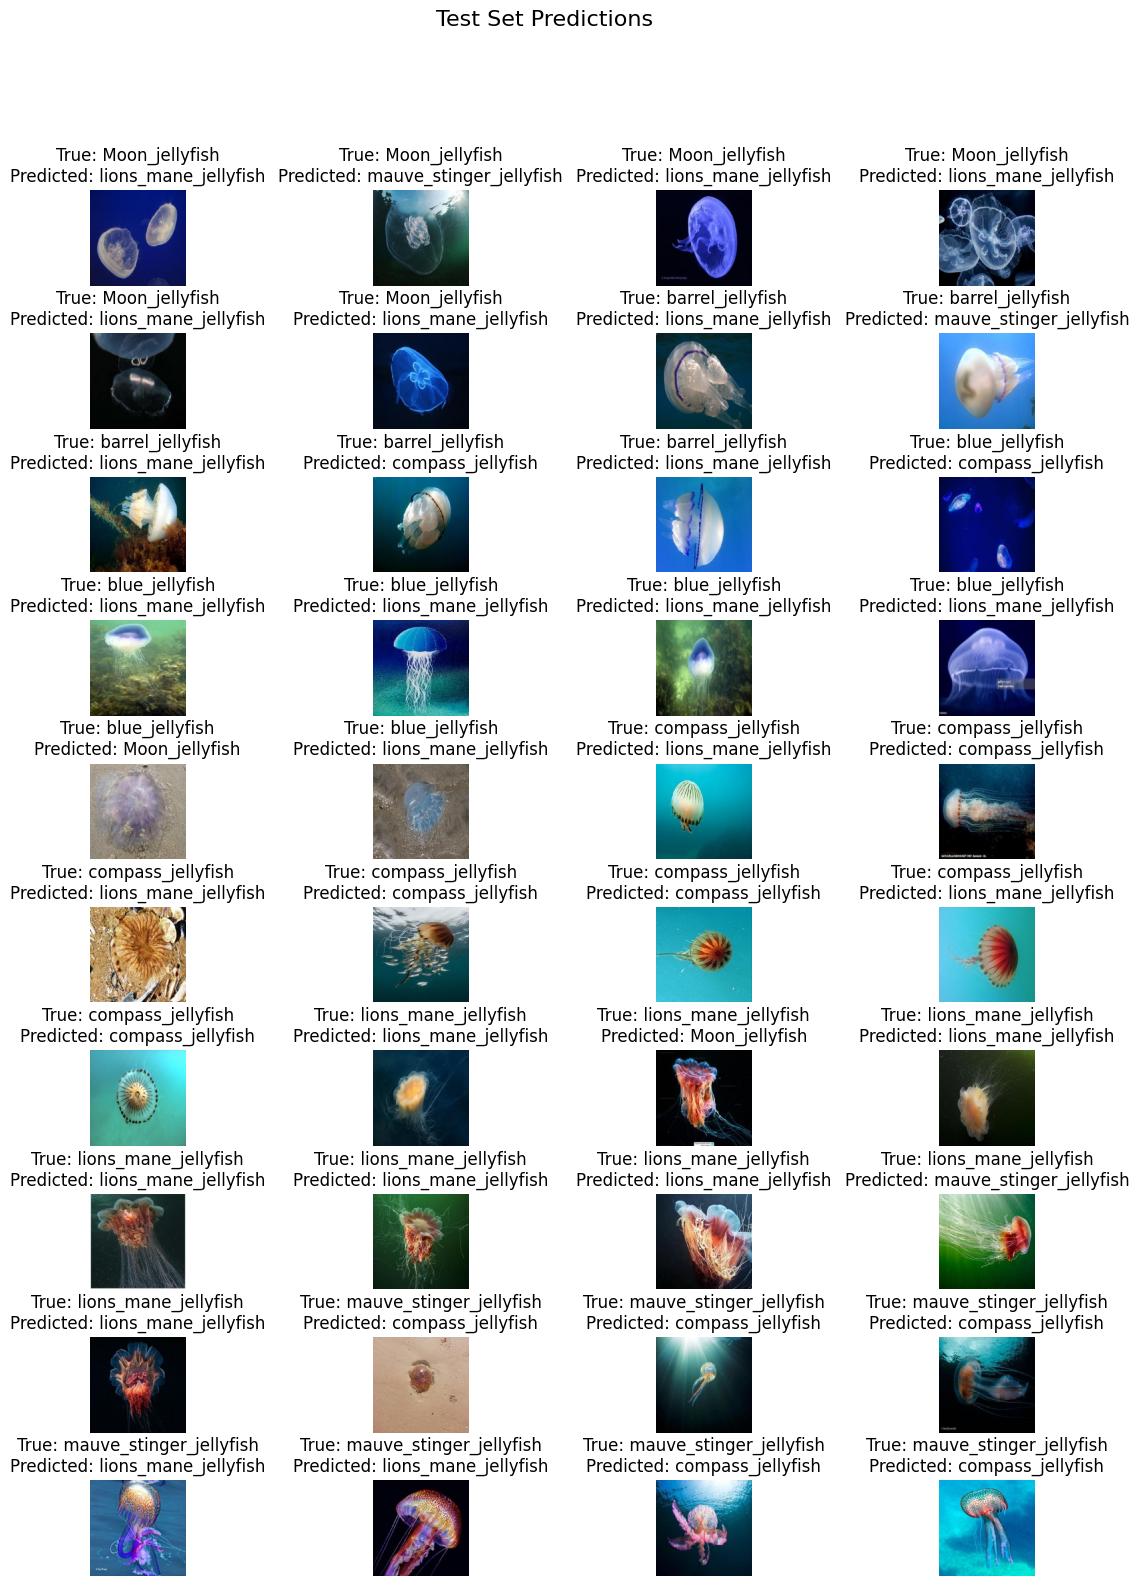

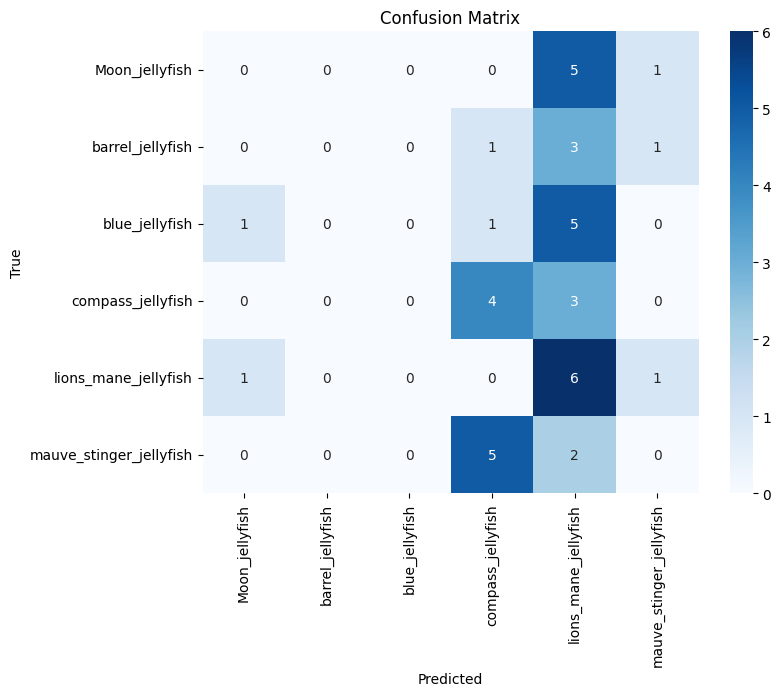

Classification Report:
                          precision    recall  f1-score   support

         Moon_jellyfish       0.00      0.00      0.00         6
       barrel_jellyfish       0.00      0.00      0.00         5
         blue_jellyfish       0.00      0.00      0.00         7
      compass_jellyfish       0.36      0.57      0.44         7
   lions_mane_jellyfish       0.25      0.75      0.38         8
mauve_stinger_jellyfish       0.00      0.00      0.00         7

               accuracy                           0.25        40
              macro avg       0.10      0.22      0.14        40
           weighted avg       0.11      0.25      0.15        40



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
plot_predictions(true_labels, predicted_labels, class_names, dataset_dir)

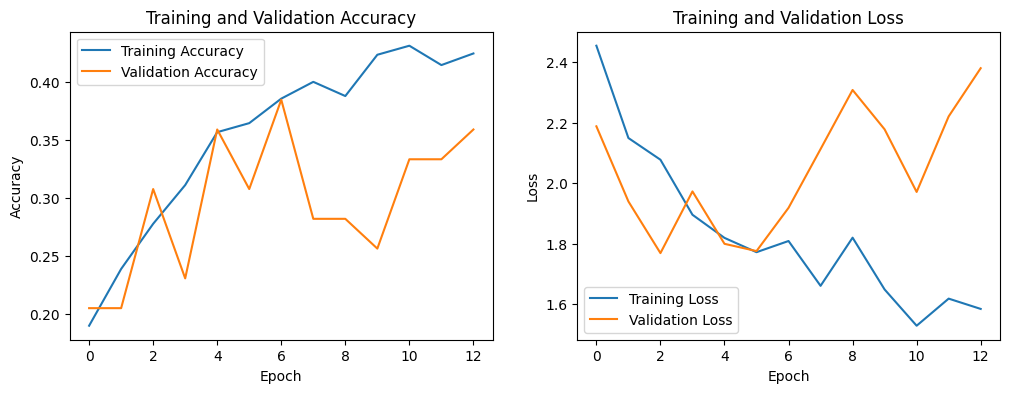

In [57]:
import matplotlib.pyplot as plt

training_history = history.history

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_history['accuracy'], label='Training Accuracy')
plt.plot(training_history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(training_history['loss'], label='Training Loss')
plt.plot(training_history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.show()